# Dataset from CoNLL003

In [23]:
import pickle
import operator
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from plot_keras_history import plot_history
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from tensorflow.keras import layers, optimizers, Model, Input

from tensorflow_addons.layers import CRF

from tensorflow_addons.text import crf_log_likelihood
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from tensorflow_addons.optimizers import AdamW
import tensorflow_addons as tfa

# Data exploration and preparation
plt.style.use("ggplot")



data_df  = pd.read_csv(f"Updated_Ner_Dataset.csv")
data_df = data_df.ffill()
data_df.tail(30)


,Sentence #,Word,POS,Tag
1048545,Sentence: 47957,Two,CD,O
1048546,Sentence: 47957,more,JJR,O
1048547,Sentence: 47957,landed,VBD,O
1048548,Sentence: 47957,in,IN,O
1048549,Sentence: 47957,fields,NNS,O
1048550,Sentence: 47957,belonging,VBG,O
1048551,Sentence: 47957,to,TO,O
1048552,Sentence: 47957,a,DT,O
1048553,Sentence: 47957,nearby,JJ,O
1048554,Sentence: 47957,village,NN,O


Total number of questions in the dataset: 47,959
Total words in the dataset: 1,048,575


<Axes: xlabel='POS'>

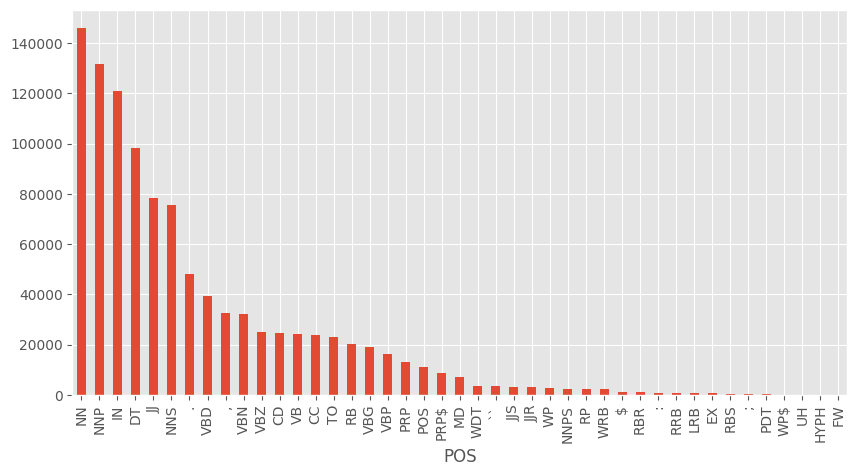

In [3]:
print("Total number of questions in the dataset: {:,}".format(data_df["Sentence #"].nunique()))
print("Total words in the dataset: {:,}".format(data_df.shape[0]))
data_df["POS"].value_counts().plot(kind="bar", figsize=(10,5))

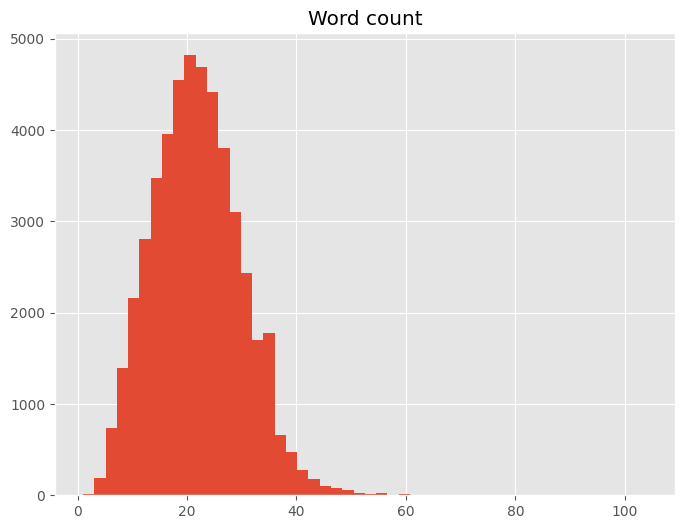

In [4]:
word_counts = data_df.groupby("Sentence #")["Word"].agg(["count"])
word_counts = word_counts.rename(columns={"count": "Word count"})
word_counts.hist(bins=50, figsize=(8,6));

In [5]:
MAX_SENTENCE = word_counts.max()[0]
print("Longest sentence in the corpus contains {} words.".format(MAX_SENTENCE))
longest_sentence_id = word_counts[word_counts["Word count"]==MAX_SENTENCE].index[0]
print("ID of the longest sentence is {}.".format(longest_sentence_id))
longest_sentence = data_df[data_df["Sentence #"]==longest_sentence_id]["Word"].str.cat(sep=' ')
print("The longest sentence in the corpus is:\n")
print(longest_sentence)
MAX_SENTENCE = 126

Longest sentence in the corpus contains 104 words.
ID of the longest sentence is Sentence: 22480.
The longest sentence in the corpus is:

Fisheries in 2006 - 7 landed 1,26,976 metric tons , of which 82 % ( 1,04,586 tons ) was krill ( Euphausia superba ) and 9.5 % ( 12,027 tons ) Patagonian toothfish ( Dissostichus eleginoides - also known as Chilean sea bass ) , compared to 1,27,910 tons in 2005 - 6 of which 83 % ( 1,06,591 tons ) was krill and 9.7 % ( 12,396 tons ) Patagonian toothfish ( estimated fishing from the area covered by the Convention of the Conservation of Antarctic Marine Living Resources ( CCAMLR ) , which extends slightly beyond the Southern Ocean area ) .


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1600\1401314207.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  MAX_SENTENCE = word_counts.max()[0]


In [6]:
all_words = list(set(data_df["Word"].values))
all_tags = list(set(data_df["Tag"].values))

print("Number of unique words: {}".format(data_df["Word"].nunique()))
print("Number of unique tags : {}".format(data_df["Tag"].nunique()))

word2index = {word: idx + 2 for idx, word in enumerate(all_words)}

word2index["--UNKNOWN_WORD--"]=0

word2index["--PADDING--"]=1

index2word = {idx: word for word, idx in word2index.items()}

for k,v in sorted(word2index.items(), key=operator.itemgetter(1))[:10]:
    print(k,v)

Number of unique words: 35213
Number of unique tags : 17
--UNKNOWN_WORD-- 0
--PADDING-- 1
31-30 2
Sevan 3
mid-February 4
Mandy 5
Lumpur 6
wa 7
Mourino 8
coercion 9


In [7]:
all_words = list(set(data_df["Word"].values))
all_tags = list(set(data_df["Tag"].values))

print("Number of unique words: {}".format(data_df["Word"].nunique()))
print("Number of unique tags : {}".format(data_df["Tag"].nunique()))

Number of unique words: 35213
Number of unique tags : 17


In [8]:
test_word = "electricity"

test_word_idx = word2index[test_word]
test_word_lookup = index2word[test_word_idx]

print("The index of the word {} is {}.".format(test_word, test_word_idx))
print("The word with index {} is {}.".format(test_word_idx, test_word_lookup))

tag2index = {tag: idx + 1 for idx, tag in enumerate(all_tags)}
tag2index["--PADDING--"] = 0

index2tag = {idx: word for word, idx in tag2index.items()}

The index of the word electricity is 21839.
The word with index 21839 is electricity.


In [9]:
def to_tuples(data):
    iterator = zip(data["Word"].values.tolist(),
                   data["POS"].values.tolist(),
                   data["Tag"].values.tolist())
    return [(word, pos, tag) for word, pos, tag in iterator]

sentences = data_df.groupby("Sentence #").apply(to_tuples).tolist()

print(sentences[0])

[('Where', 'WRB', 'O'), ('is', 'VBZ', 'O'), ('Wardenclyffe', 'NNP', 'B-org'), ('Tower', 'NNP', 'I-org'), ('located', 'VBN', 'O'), ('?', '.', 'O')]


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1600\3085017882.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sentences = data_df.groupby("Sentence #").apply(to_tuples).tolist()


In [10]:
X = [[word[0] for word in sentence] for sentence in sentences]
y = [[word[2] for word in sentence] for sentence in sentences]
print("X[0]:", X[0])
print("y[0]:", y[0])

X = [[word2index[word] for word in sentence] for sentence in X]
y = [[tag2index[tag] for tag in sentence] for sentence in y]
print("X[0]:", X[0])
print("y[0]:", y[0])

X = [sentence + [word2index["--PADDING--"]] * (MAX_SENTENCE - len(sentence)) for sentence in X]
y = [sentence + [tag2index["--PADDING--"]] * (MAX_SENTENCE - len(sentence)) for sentence in y]
print("X[0]:", X[0])
print("y[0]:", y[0])

X[0]: ['Where', 'is', 'Wardenclyffe', 'Tower', 'located', '?']
y[0]: ['O', 'O', 'B-org', 'I-org', 'O', 'O']
X[0]: [21676, 433, 13336, 9246, 7317, 11263]
y[0]: [9, 9, 3, 13, 9, 9]
X[0]: [21676, 433, 13336, 9246, 7317, 11263, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
y[0]: [9, 9, 3, 13, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [11]:
TAG_COUNT = len(tag2index)
y = [ np.eye(TAG_COUNT)[sentence] for sentence in y]
print("X[0]:", X[0])
print("y[0]:", y[0])

X[0]: [21676, 433, 13336, 9246, 7317, 11263, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
y[0]: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1234)

print("Number of sentences in the training dataset: {}".format(len(X_train)))
print("Number of sentences in the test dataset : {}".format(len(X_test)))

#convert to Numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

Number of sentences in the training dataset: 43163
Number of sentences in the test dataset : 4796


In [13]:
WORD_COUNT = len(index2word)
DENSE_EMBEDDING = 50
LSTM_UNITS = 50
LSTM_DROPOUT = 0.1
DENSE_UNITS = 100
BATCH_SIZE = 256
MAX_EPOCHS = 10



def crf_loss_func(potentials, sequence_length, kernel, y):
    crf_likelihood, _ = crf_log_likelihood(
        potentials, y, sequence_length, kernel
    )
    # likelihood to loss
    flat_crf_loss = -1 * crf_likelihood
    crf_loss = tf.reduce_mean(flat_crf_loss)

    return crf_loss

In [14]:
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from tensorflow_addons.optimizers import AdamW

input_layer = layers.Input(shape=(MAX_SENTENCE,))

model = layers.Embedding(WORD_COUNT, DENSE_EMBEDDING, embeddings_initializer="uniform", input_length=MAX_SENTENCE)(input_layer)

model = layers.Bidirectional(layers.LSTM(LSTM_UNITS, recurrent_dropout=LSTM_DROPOUT, return_sequences=True))(model)

model = layers.TimeDistributed(layers.Dense(DENSE_UNITS, activation="relu"))(model)

crf_layer = CRF(units=TAG_COUNT, name='crf_layer')

#output_layer = crf_layer(model)
predicted_sequence, potentials, sequence_length, crf_kernel = crf_layer(model)

ner_model = Model(input_layer, potentials)

ner_model.compile(
      optimizer=AdamW(weight_decay=0.001),
      loss=SigmoidFocalCrossEntropy(),
      metrics=["accuracy"])

ner_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 126)]             0         
                                                                 
 embedding (Embedding)       (None, 126, 50)           1760750   
                                                                 
 bidirectional (Bidirectiona  (None, 126, 100)         40400     
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 126, 100)         10100     
 ibuted)                                                         
                                                                 
 crf_layer (CRF)             [(None, 126),             2178      
                              (None, 126, 18),                   
                              (None,),                       

In [15]:
from tensorflow.keras.utils import plot_model
plot_model(ner_model,'ner_model.png',show_shapes= True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [16]:
history = ner_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=MAX_EPOCHS, validation_split=0.1, verbose=2)

Epoch 1/10
152/152 - 70s - loss: 0.0661 - accuracy: 0.9481 - val_loss: 0.0220 - val_accuracy: 0.9729 - 70s/epoch - 460ms/step
Epoch 2/10
152/152 - 69s - loss: 0.0181 - accuracy: 0.9735 - val_loss: 0.0124 - val_accuracy: 0.9756 - 69s/epoch - 451ms/step
Epoch 3/10
152/152 - 68s - loss: 0.0098 - accuracy: 0.9815 - val_loss: 0.0094 - val_accuracy: 0.9832 - 68s/epoch - 448ms/step
Epoch 4/10
152/152 - 74s - loss: 0.0079 - accuracy: 0.9865 - val_loss: 0.0083 - val_accuracy: 0.9882 - 74s/epoch - 484ms/step
Epoch 5/10
152/152 - 77s - loss: 0.0101 - accuracy: 0.9884 - val_loss: 0.0457 - val_accuracy: 0.9850 - 77s/epoch - 504ms/step
Epoch 6/10
152/152 - 78s - loss: 0.0101 - accuracy: 0.9849 - val_loss: 0.0082 - val_accuracy: 0.9870 - 78s/epoch - 515ms/step
Epoch 7/10
152/152 - 78s - loss: 0.0069 - accuracy: 0.9889 - val_loss: 0.0078 - val_accuracy: 0.9883 - 78s/epoch - 514ms/step
Epoch 8/10
152/152 - 75s - loss: 0.0063 - accuracy: 0.9899 - val_loss: 0.0075 - val_accuracy: 0.9888 - 75s/epoch - 495

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

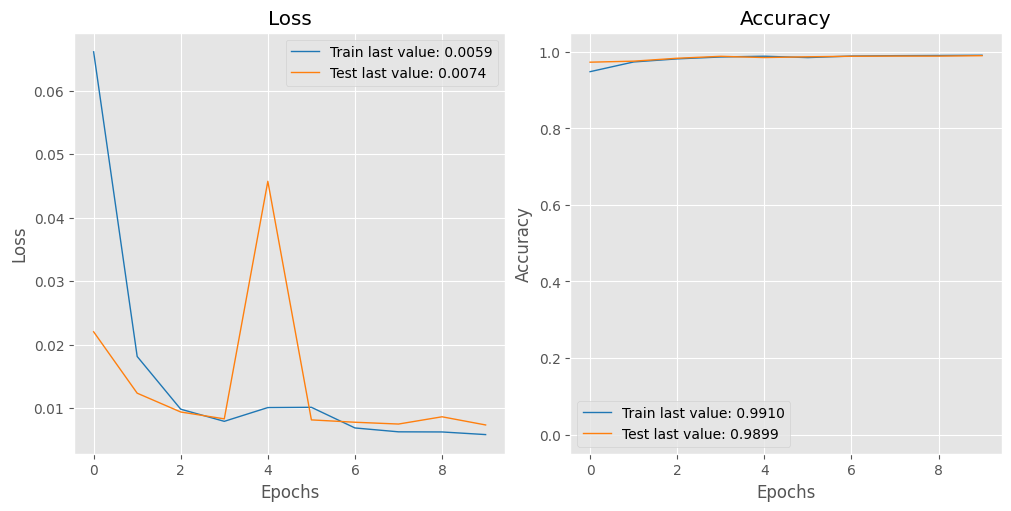

In [17]:
plot_history(history.history)

In [18]:
y_pred = ner_model.predict(X_test)

y_pred = np.argmax(y_pred, axis=2)

y_test = np.argmax(y_test, axis=2)

accuracy = (y_pred == y_test).mean()

print("Accuracy: {:.4f}/".format(accuracy))

150/150 [==============================] - 4s 21ms/step
Accuracy: 0.9898/


In [19]:
def tag_conf_matrix(cm, tagid):
    tag_name = index2tag[tagid]
    print("Tag name: {}".format(tag_name))
    print(cm[tagid])
    tn, fp, fn, tp = cm[tagid].ravel()
    tag_acc = (tp + tn) / (tn + fp + fn + tp)
    print("Tag accuracy: {:.3f} \n".format(tag_acc))

matrix = multilabel_confusion_matrix(y_test.flatten(), y_pred.flatten())

tag_conf_matrix(matrix, 8)
tag_conf_matrix(matrix, 14)

Tag name: B-geo
[[599113   1393]
 [   455   3335]]
Tag accuracy: 0.997 

Tag name: B-per
[[602499    138]
 [   877    782]]
Tag accuracy: 0.998 



In [24]:
sentence = "Where is Grand Street located?"

re_tok = re.compile(f"([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])")
sentence = re_tok.sub(r"  ", sentence).split()

padded_sentence = sentence + [word2index["--PADDING--"]] * (MAX_SENTENCE - len(sentence))
padded_sentence = [word2index.get(w, 0) for w in padded_sentence]

pred = ner_model.predict(np.array([padded_sentence]))
pred = np.argmax(pred, axis=-1)

retval = ""
for w, p in zip(sentence, pred[0]):
    retval = retval + "{:15}: {:5}".format(w, index2tag[p]) + "\n"

print(retval)

1/1 [==============================] - 0s 24ms/step
Where          : O    
is             : O    
Grand          : B-org
Street         : B-org
located        : O    



In [21]:
model_save_path = f"Trained Models/Ner_BiLSTM_CRF"
ner_model.save(model_save_path)

INFO:tensorflow:Assets written to: Trained Models/Ner_BiLSTM_CRF\assets


INFO:tensorflow:Assets written to: Trained Models/Ner_BiLSTM_CRF\assets


In [22]:
with open('Trained Models/word2index.pkl', 'wb') as file:
    pickle.dump(word2index, file)

# Save MAX_SENTENCE
with open('Trained Models/max_sentence.pkl', 'wb') as file:
    pickle.dump(MAX_SENTENCE, file)

# Save index2tag dictionary
with open('Trained Models/index2tag.pkl', 'wb') as file:
    pickle.dump(index2tag, file)

In [25]:
new_model = tf.keras.models.load_model(model_save_path, custom_objects={'CRF': CRF})

In [26]:
data=pd.read_excel("Questions.xlsx")
df = pd.DataFrame(data)

sentences = df['Question'].astype(str)

In [27]:
def predict_ne(sentence):
  re_tok = re.compile(f"([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])")
  sentence = re_tok.sub(r"  ", sentence).split()

  padded_sentence = sentence + [word2index["--PADDING--"]] * (MAX_SENTENCE - len(sentence))
  padded_sentence = [word2index.get(w, 0) for w in padded_sentence]

  pred = new_model.predict(np.array([padded_sentence]))
  pred = np.argmax(pred, axis=-1)

  retval = ""
  for w, p in zip(sentence, pred[0]):
      retval = retval + "{:15}: {:5}".format(w, index2tag[p]) + "\n"

  print(retval)

  # Apply the prediction function to each sentence in the DataFrame
df['predictions'] = sentences.apply(predict_ne)

1/1 [==============================] - 0s 422ms/step
What           : O    
did            : O    
Marie          : B-per
Curie          : O    
discover       : O    

1/1 [==============================] - 0s 26ms/step
What           : O    
is             : O    
radium         : O    

1/1 [==============================] - 0s 30ms/step
What           : O    
is             : O    
polonium       : O    

1/1 [==============================] - 0s 25ms/step
How            : B-per
did            : O    
Marie          : I-per
Curie          : O    
study          : O    
radioactivity  : O    

1/1 [==============================] - 0s 27ms/step
What           : O    
was            : O    
Marie          : B-per
Curie          : O    
s              : O    
role           : O    
in             : O    
developing     : O    
X              : O    
ray            : O    
technology     : O    

1/1 [==============================] - 0s 25ms/step
How            : B-per
did            